In [6]:
from brainio.fetch import get_stimulus_set
from model_tools.brain_transformation.neural import LayerMappedModel
from bonner.models.alexnet_imagenet import alexnet_imagenet
from bonner.brainscore.benchmarks.bonner2021_object2vec import extract_features
from unittest.mock import patch

In [12]:
""" Blackbox Attack [Project: visualsemantic]

(See blackbox_attack.py for an excutable version.)

This script performs "blackbox attack" on encoders by generating predicted voxels from synthesized images
and comparing the average activations with normal images. 

This script contains the following functions and classes:


"""

import os
import h5py
import pickle
import numpy as np
import xarray as xr
from scipy import spatial
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

from src.utils import listdir
from src.neural_transfer import image_loader, imshow

import torch
import xarray as xr

from brainscore.metrics.regression import (
    linear_regression,
    pearsonr_correlation,
)

from model_tools.brain_transformation.neural import LayerScores
from model_tools.analyses import ActivationsModel

from brainio.fetch import get_stimulus_set
from brainio.stimuli import StimulusSet
from brainscore.model_interface import BrainModel
from bonner.models.alexnet_imagenet import alexnet_imagenet
from bonner.brainscore.benchmarks.bonner2021_object2vec import load_assembly, N_SUBJECTS, extract_features

# from brainio.assemblies import NeuroidAssembly, walk_coords
# from brainscore.metrics.xarray_utils import map_target_to_source

# from model_tools.activations.hooks import GlobalMaxPool2d
# from model_tools.brain_transformation.neural import LayerMappedModel, PreRunLayers
# from model_tools.brain_transformation.temporal import TemporalIgnore


In [149]:
layers = ["features.10"]

#model = alexnet_imagenet(identifier="alexnet-test")
#candidate_model = LayerMappedModel("alexnet-test", model, {None: "features.10"})
#x = extract_features(candidate_model, stimulus_set=get_stimulus_set("bonner2021.object2vec-texture"))


# getting an ActivationsModel (basically a normal Pytorch model wrapped in model_tools.activations.pytorch.PytorchWrapper)
model = alexnet_imagenet()

# wrapping that model in model_tools.brain_transformation.neural.LayerMappedModel to convert it into a brainscore.model_interface.BrainModel
model = LayerMappedModel(
    identifier="alexnet-features_.10",
    activations_model=model,
    region_layer_map={None: layers[0]},  # specifying what CNN layers we wanna use
    visual_degrees=None,
)

# using the images with textured backgrounds
stimulus_set = get_stimulus_set("bonner2021.object2vec-texture")

# using an extract_features function defined by me instead of directly doing model(stimulus_set) because Object2Vec has some annoyances (need to average across images within a category since it's a block design)
model_assembly = extract_features(model, stimulus_set)



In [150]:
# extract betas

rois = ['FFA', 'EBA', 'PPA', 'LOC', 'EVC']
betas = {roi: {} for roi in rois}
for roi in rois:
    print(roi)
    for subject in range(4):
        print(subject)
        neural_assembly = load_assembly(
            subject,
            average_reps=False,
            z_score=True,
            check_integrity=False,
            kwargs_filter={
                "rois": (
                    roi,

                )
            }
        )
        regression = linear_regression(
            backend="pytorch",
            torch_kwargs={"device": "cpu"},
        )
        regression.fit(model_assembly, neural_assembly)
        # if using the Pytorch backend I wrote, the betas are currently stored in the `betas` attribute
        # I'll change it to follow the sklearn API later to be more consistent
        betas[roi][subject] = regression._regression.betas

FFA
0
1
2
3
EBA
0
1
2
3
PPA
0
1
2
3
LOC
0
1
2
3
EVC
0
1
2
3


<KeysViewHDF5 ['pooled_composite', 'pooled_obs', 'pooled_pred', 'rois', 'subj_obs', 'subj_pred']>


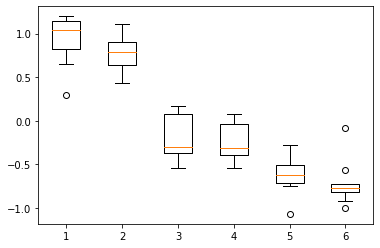

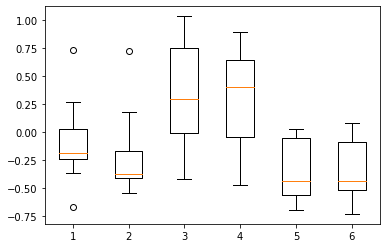

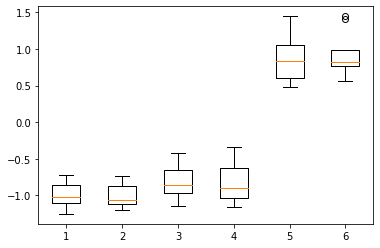

In [162]:
## Load input betas from Murty et al. images

f = h5py.File('../../visualsemantic/stimuli/L2_data.mat','r')
L2data = f.get('L2_data')
print(L2data.keys())
L2data_rois = (L2data.get('rois'))

conditions = ["face", "place", "body", "object"]
condition_idx = {"face": np.arange(26,51),
                "place": np.concatenate((np.arange(76,101), np.arange(126,151)), axis=None),
                "body": np.concatenate((np.arange(1,26), np.arange(101,126)), axis=None),
                "object": np.concatenate((np.arange(51,76), np.arange(151,186)), axis=None)}


pooled_obs = np.array(L2data.get('pooled_obs'))
pooled_pred = np.array(L2data.get('pooled_pred'))

best_face = np.stack((pooled_pred[:, 0], pooled_pred[:, 1]), axis=1).mean(axis=1).argsort()[-10:][::-1]
best_body = np.stack((pooled_pred[:, 2], pooled_pred[:, 3]), axis=1).mean(axis=1).argsort()[-10:][::-1]
best_place = np.stack((pooled_pred[:, 4], pooled_pred[:, 5]), axis=1).mean(axis=1).argsort()[-10:][::-1]
best_object = condition_idx["object"][:10]


condition_best_idx = {"face": best_face,
                      "body": best_body,
                      "place": best_place,
                     "object": best_object}

# plt.figure()
# _ = plt.boxplot(pooled_obs[condition_idx['face']-1])
# plt.figure()
# _ = plt.boxplot(pooled_obs[condition_idx['body']-1])
# plt.figure()
# _ = plt.boxplot(pooled_obs[condition_idx['place']-1])

# plt.figure()
# _ = plt.boxplot(pooled_pred[condition_idx['face']-1])
# plt.figure()
# _ = plt.boxplot(pooled_pred[condition_idx['body']-1])
# plt.figure()
# _ = plt.boxplot(pooled_pred[condition_idx['place']-1])

# Screened for best 10 images
plt.figure()
_ = plt.boxplot(pooled_pred[best_face-1])
plt.figure()
_ = plt.boxplot(pooled_pred[best_body-1])
plt.figure()
_ = plt.boxplot(pooled_pred[best_place-1])

In [163]:

## Get activations for encoder-predicted top-category images 

condition_imgs = {c: [] for c in conditions}
stim_path = "../../visualsemantic/stimuli/stimuli"
stim_images = listdir(stim_path)
for condition in conditions:
    condition_imgs[condition] = [stim_images[idx] for idx in condition_best_idx[condition]]


condition= 'face'
face_activations = alexnet_imagenet()(
    [ci for ci in condition_imgs[condition]], layers=layers, stimuli_identifier="best_face_." + " ".join(layers)
)
condition = 'place'
scene_activations = alexnet_imagenet()(
    [ci for ci in condition_imgs[condition]], layers=layers, stimuli_identifier="best_scene_." + " ".join(layers)
)
condition = 'body'
body_activations = alexnet_imagenet()(
    [ci for ci in condition_imgs[condition]], layers=layers, stimuli_identifier="best_body_." + " ".join(layers)
)

condition = 'object'
object_activations = alexnet_imagenet()(
    [ci for ci in condition_imgs[condition]], layers=layers, stimuli_identifier="best_object_." + " ".join(layers)
)

cond_activations = {'face': face_activations.values,
                   'place': scene_activations.values,
                   'body': body_activations.values,
                   'object': object_activations.values}

FFA face tensor(-0.2427)
FFA place tensor(-0.0931)
FFA body tensor(-0.1217)
FFA object tensor(-0.0638)
EBA face tensor(0.1270)
EBA place tensor(0.3257)
EBA body tensor(0.5481)
EBA object tensor(-0.0207)
PPA face tensor(0.1355)
PPA place tensor(0.1582)
PPA body tensor(-0.0065)
PPA object tensor(0.1740)
LOC face tensor(-0.2168)
LOC place tensor(-0.1172)
LOC body tensor(0.0595)
LOC object tensor(-0.1006)
EVC face tensor(-0.5215)
EVC place tensor(-0.0365)
EVC body tensor(-0.2488)
EVC object tensor(-0.1524)


/home/chan21/.conda/envs/bonner-lab-kelsey/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/chan21/.conda/envs/bonner-lab-kelsey/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/chan21/.conda/envs/bonner-lab-kelsey/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code

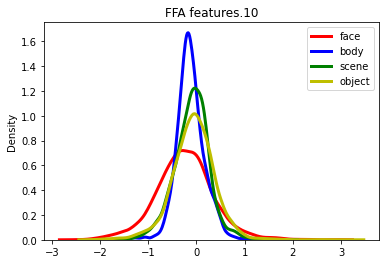

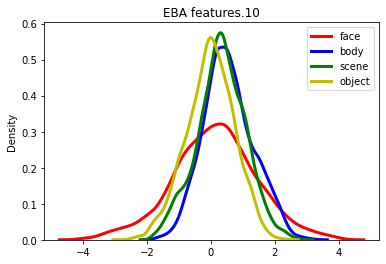

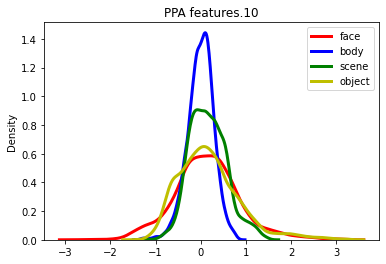

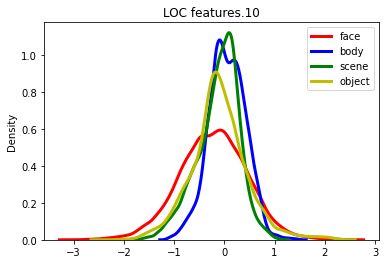

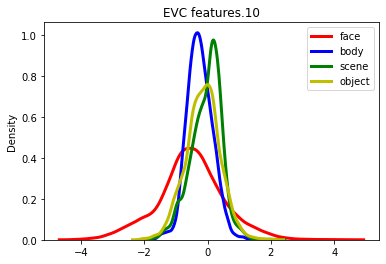

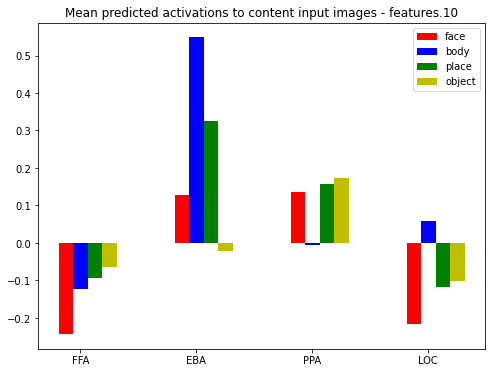

In [164]:
## Get predictions for best predicted top-category images

cond_predicted = {roi: {cond: [] for cond in conditions} for roi in rois}

for roi in rois:
    for condition in conditions:
        data = cond_activations[condition]
        content_predicted = np.matmul(data, betas[roi][0])
        print(roi, condition, content_predicted.mean())
        cond_predicted[roi][condition] = content_predicted
        
for roi in rois:
    plt.figure()
    plt.title(roi + " " + "".join(layers))
    sns.distplot(cond_predicted[roi]['face'], hist=False, kde=True, 
                 color = 'r',
                 kde_kws = {'linewidth': 3},
                label = "face")
    sns.distplot(cond_predicted[roi]['body'], hist=False, kde=True, 
                 color = 'b',
                 kde_kws = {'linewidth': 3},
                label = "body")
    sns.distplot(cond_predicted[roi]['place'], hist=False, kde=True, 
             color = 'g',
             kde_kws = {'linewidth': 3},
            label = "scene")
    sns.distplot(cond_predicted[roi]['object'], hist=False, kde=True, 
             color = 'y',
             kde_kws = {'linewidth': 3},
            label = "object")
    _ = plt.legend()
    
    
# Plot mean predicted activations to input images
plt.figure(figsize=(8,6))
plt.title("Mean predicted activations to content input images - " + "".join(layers))
X = np.array([0, 1, 2, 3])
plt.bar(X + 0.00,
        [cond_predicted['FFA']['face'].mean(axis=1).mean(),
         cond_predicted['EBA']['face'].mean(axis=1).mean(),
         cond_predicted['PPA']['face'].mean(axis=1).mean(),
         cond_predicted['LOC']['face'].mean(axis=1).mean()],
       color='r',
       width=0.125,
       label='face')

plt.bar(X + 0.125,
        [cond_predicted['FFA']['body'].mean(axis=1).mean(),
         cond_predicted['EBA']['body'].mean(axis=1).mean(),
         cond_predicted['PPA']['body'].mean(axis=1).mean(),
         cond_predicted['LOC']['body'].mean(axis=1).mean()],
       color='b',
       width=0.125,
       label='body')

plt.bar(X + 0.25,
        [cond_predicted['FFA']['place'].mean(axis=1).mean(),
         cond_predicted['EBA']['place'].mean(axis=1).mean(),
         cond_predicted['PPA']['place'].mean(axis=1).mean(),
         cond_predicted['LOC']['place'].mean(axis=1).mean()],
       color='g',
       width=0.125,
       label='place')
plt.bar(X + 0.375,
        [cond_predicted['FFA']['object'].mean(axis=1).mean(),
         cond_predicted['EBA']['object'].mean(axis=1).mean(),
         cond_predicted['PPA']['object'].mean(axis=1).mean(),
         cond_predicted['LOC']['object'].mean(axis=1).mean()
        ],
       color='y',
       width=0.125,
       label='object')

plt.xticks(X+0.125, ['FFA', 'EBA', 'PPA', 'LOC'])
_ = plt.legend()

In [93]:
## Load input images for categories, using expert ratings

# f = h5py.File('../../visualsemantic/stimuli/L2_data.mat','r')
# L2data = f.get('L2_data')
# print(L2data.keys())
# L2data_rois = (L2data.get('rois'))

# print([L2data[stuff] for stuff in L2data.keys()])
#print(np.array(L2data['pooled_obs']))

f = h5py.File('../../visualsemantic/stimuli/L2_experts.mat','r')
L2expert = f.get('L2_experts')
expert_face = np.array(L2expert.get('facedata').get('data'))
expert_place = np.array(L2expert.get('scenedata').get('data'))
expert_body = np.array(L2expert.get('bodydata').get('data'))
expert_face_idx = expert_face.mean(axis=1).argsort()[-10:][::-1]
expert_place_idx = expert_scene.mean(axis=1).argsort()[-10:][::-1]
expert_body_idx = expert_body.mean(axis=1).argsort()[-10:][::-1]


conditions = ["face", "place", "body"]
condition_idx = {"face": expert_face_idx,
                "place": expert_place_idx,
                "body": expert_body_idx}
condition_imgs = {c: [] for c in conditions}
stim_path = "../../visualsemantic/stimuli/stimuli"
stim_images = listdir(stim_path)
for condition in conditions:
    condition_imgs[condition] = [stim_images[idx] for idx in condition_idx[condition]]


## Get activations for expert-rated top-category images    
condition= 'face'
face_activations = alexnet_imagenet(
    [ci for ci in condition_imgs[condition]], layers=layers, stimuli_identifier="expert_face." + " ".join(layers)
)
condition = 'place'
scene_activations = alexnet_imagenet(
    [ci for ci in condition_imgs[condition]], layers=layers, stimuli_identifier="expert_scene." + " ".join(layers)
)
condition = 'body'
body_activations = alexnet_imagenet(
    [ci for ci in condition_imgs[condition]], layers=layers, stimuli_identifier="expert_body." + " ".join(layers)
)

cond_activations = {'face': face_activations.values,
                   'place': scene_activations.values,
                   'body': body_activations.values}

NameError: name 'expert_scene' is not defined

FFA face 0.17650494
FFA place -0.004744876
FFA body 0.2295332
PPA face 0.5435475
PPA place -0.3459215
PPA body -0.063852824
EBA face 0.5772681
EBA place 0.28190842
EBA body 0.4193165


/home/chan21/.conda/envs/bonner-lab-kelsey/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/chan21/.conda/envs/bonner-lab-kelsey/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/chan21/.conda/envs/bonner-lab-kelsey/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code

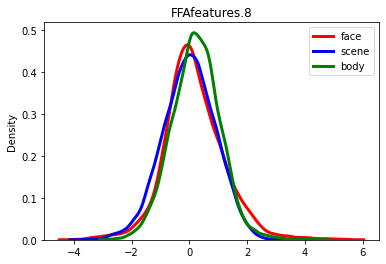

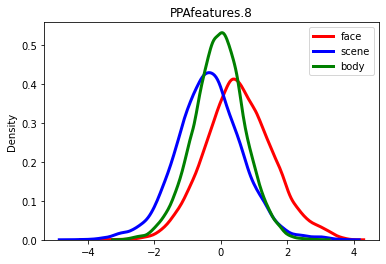

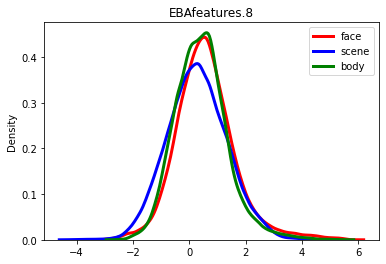

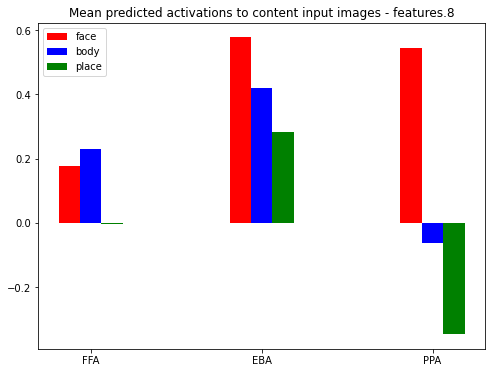

In [355]:

## Get predictions for expert-rated top-category images

rois = ['FFA', 'PPA', 'EBA']
conditions = ['face', 'place', 'body']
cond_predicted = {roi: {cond: [] for cond in conditions} for roi in rois}

for roi in rois:
    for condition in conditions:
        data = cond_activations[condition]
        # scaler = preprocessing.StandardScaler().fit(data) # normalize and get predicted activations
        # data = scaler.transform(data)
        content_predicted = np.matmul(data, betas[roi])
        print(roi, condition, content_predicted.mean())
        cond_predicted[roi][condition] = content_predicted
        
        
for roi in rois:
    
    plt.figure()
    plt.title(roi + "".join(layers))
    sns.distplot(cond_predicted[roi]['face'], hist=False, kde=True, 
                 color = 'r',
                 kde_kws = {'linewidth': 3},
                label = "face")
    sns.distplot(cond_predicted[roi]['place'], hist=False, kde=True, 
                 color = 'b',
                 kde_kws = {'linewidth': 3},
                label = "scene")
    sns.distplot(cond_predicted[roi]['body'], hist=False, kde=True, 
                 color = 'g',
                 kde_kws = {'linewidth': 3},
                label = "body")
    
    _ = plt.legend()
    

# Plot mean predicted activations to input images
plt.figure(figsize=(8,6))
plt.title("Mean predicted activations to content input images - " + "".join(layers))
X = np.array([0, 1, 2])
plt.bar(X + 0.00,
        [cond_predicted['FFA']['face'].mean(axis=1).mean(),
         cond_predicted['EBA']['face'].mean(axis=1).mean(),
         cond_predicted['PPA']['face'].mean(axis=1).mean()],
       color='r',
       width=0.125,
       label='face')

plt.bar(X + 0.125,
        [cond_predicted['FFA']['body'].mean(axis=1).mean(),
         cond_predicted['EBA']['body'].mean(axis=1).mean(),
         cond_predicted['PPA']['body'].mean(axis=1).mean()],
       color='b',
       width=0.125,
       label='body')

plt.bar(X + 0.25,
        [cond_predicted['FFA']['place'].mean(axis=1).mean(),
         cond_predicted['EBA']['place'].mean(axis=1).mean(),
         cond_predicted['PPA']['place'].mean(axis=1).mean()],
       color='g',
       width=0.125,
       label='place')

plt.xticks(X+0.125, ['FFA', 'EBA', 'PPA'])
_ = plt.legend()


In [ ]:

# Load input images for black-box attack
conditions = ["face", "place", "object"]
condition_imgs = {c: [] for c in conditions}
for condition in conditions:
    stim_path = "../../visualsemantic/stimuli/" + condition
    images = listdir(stim_path)
    condition_imgs[condition] = [img.split("/")[-1] for img in images]

result_path = "../../visualsemantic/results/adversary"
results = [item.split("/")[-1] for item in listdir(result_path) if ".png" in item]

synthesized_outputs = [item for item in results if len(item.split("_")) > 1]
content_inputs = list(
    set([item.split("_")[0] + ".png" for item in synthesized_outputs])
)
style_inputs = list(
    set([item.split("_")[1].split(".")[0] + ".png" for item in synthesized_outputs])
)

# Get activations for input and output images    
content_activations = alexnet_imagenet(
    [os.path.join(result_path, ci) for ci in content_inputs], layers=layers, stimuli_identifier="content." + " ".join(layers)
)

style_activations = alexnet_imagenet(
    [os.path.join(result_path, si) for si in style_inputs], layers=layers, stimuli_identifier="style." + " ".join(layers)
)

output_activations = alexnet_imagenet(
    [os.path.join(result_path, o) for o in synthesized_outputs], layers=layers, stimuli_identifier="synthesized." + " ".join(layers)
)

In [8]:

content_path_face = [os.path.join(result_path, ci) for ci in content_inputs if 'face' in ci.split('/')[-1]]
content_idx_face = [np.where(content_activations['stimulus_path'].values == ci)[0][0] for ci in content_path_face]
content_path_object = [os.path.join(result_path, ci) for ci in content_inputs if 'object' in ci.split('/')[-1]]
content_idx_object = [np.where(content_activations['stimulus_path'].values == ci)[0][0] for ci in content_path_object]
content_path_place = [os.path.join(result_path, ci) for ci in content_inputs if 'place' in ci.split('/')[-1]]
content_idx_place = [np.where(content_activations['stimulus_path'].values == ci)[0][0] for ci in content_path_place]


# style_path_face = [os.path.join(result_path, si) for si in style_inputs if 'face' in si.split('/')[-1]]
# style_idx_face = [np.where(style_activations['stimulus_path'].values == si)[0][0] for si in style_path_face]
# style_path_object = [os.path.join(result_path, si) for si in style_inputs if 'object' in si.split('/')[-1]]
# style_idx_object = [np.where(style_activations['stimulus_path'].values == si)[0][0] for si in style_path_object]
# style_path_place = [os.path.join(result_path, si) for si in style_inputs if 'place' in si.split('/')[-1]]
# style_idx_place = [np.where(style_activations['stimulus_path'].values == si)[0][0] for si in style_path_place]



# synthesized_path_face = [os.path.join(result_path, o) for o in synthesized_outputs if 'face' in o.split('/')[-1].split('_')[0]]
# synthesized_idx_face = [np.where(output_activations['stimulus_path'].values == o)[0][0] for o in synthesized_path_face]
# synthesized_path_object = [os.path.join(result_path, o) for o in synthesized_outputs if 'object' in o.split('/')[-1].split('_')[0]]
# synthesized_idx_object = [np.where(output_activations['stimulus_path'].values == o)[0][0] for o in synthesized_path_object]
# synthesized_path_place = [os.path.join(result_path, o) for o in synthesized_outputs if 'place' in o.split('/')[-1].split('_')[0]]
# synthesized_idx_place = [np.where(output_activations['stimulus_path'].values == o)[0][0] for o in synthesized_path_place]


In [41]:

content_activations_face = np.stack([content_activations.isel({"stimulus_path": idx}).values for idx in content_idx_face])
content_activations_object = np.stack([content_activations.isel({"stimulus_path": idx}).values for idx in content_idx_object])
content_activations_place = np.stack([content_activations.isel({"stimulus_path": idx}).values for idx in content_idx_place])

# style_activations_face = np.stack([style_activations.isel({"stimulus_path": idx}).values for idx in style_idx_face])
# style_activations_object = np.stack([style_activations.isel({"stimulus_path": idx}).values for idx in style_idx_face])
# style_activations_place = np.stack([style_activations.isel({"stimulus_path": idx}).values for idx in style_idx_face])


# output_activations_face = np.stack([output_activations.isel({"stimulus_path": idx}).values for idx in synthesized_idx_face])
# output_activations_object = np.stack([output_activations.isel({"stimulus_path": idx}).values for idx in synthesized_idx_face])
# output_activations_place = np.stack([output_activations.isel({"stimulus_path": idx}).values for idx in synthesized_idx_face])


/home/chan21/.conda/envs/bonner-lab-kelsey/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/chan21/.conda/envs/bonner-lab-kelsey/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/chan21/.conda/envs/bonner-lab-kelsey/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code

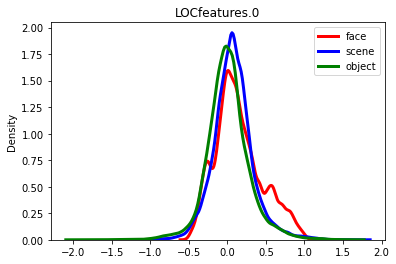

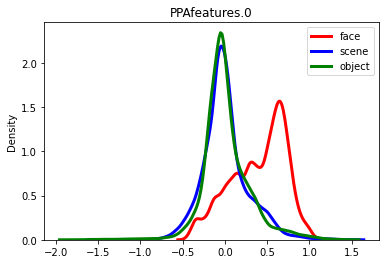

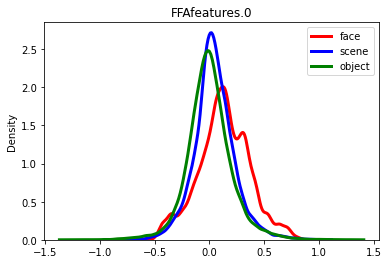

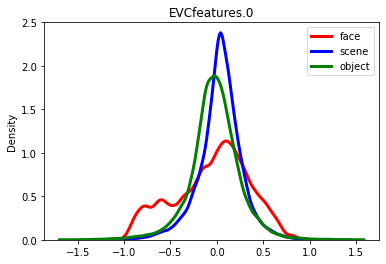

In [139]:
# cond_activations = {'face': [content_activations_face, style_activations_face, output_activations_face],
#                    'object': [content_activations_object, style_activations_object, output_activations_object],
#                    'place': [content_activations_place, style_activations_place, output_activations_place]}


cond_predicted = {'FFA': {'face': [],
                         'object': [],
                         'place': []},
                 'PPA': {'face': [],
                         'object': [],
                         'place': []},
                 'LOC': {'face': [],
                         'object': [],
                         'place': []},
                 'EVC': {'face': [],
                         'object': [],
                         'place': []}}

for condition in conditions:
    for roi in rois:
        nImgsContent = len(cond_activations[condition])
        
        data = cond_activations[condition]
        # scaler = preprocessing.StandardScaler().fit(data) # normalize and get predicted activations
        # data = scaler.transform(data)
        content_predicted = np.matmul(data, betas[roi])

        cond_predicted[roi][condition] = content_predicted

        
for roi in rois:
    
    plt.figure()
    plt.title(roi + "".join(layers))
    sns.distplot(cond_predicted[roi]['face'], hist=False, kde=True, 
                 color = 'r',
                 kde_kws = {'linewidth': 3},
                label = "face")
    sns.distplot(cond_predicted[roi]['place'], hist=False, kde=True, 
                 color = 'b',
                 kde_kws = {'linewidth': 3},
                label = "scene")
    sns.distplot(cond_predicted[roi]['object'], hist=False, kde=True, 
                 color = 'g',
                 kde_kws = {'linewidth': 3},
                label = "object")
    _ = plt.legend()

KeyError: 'place'

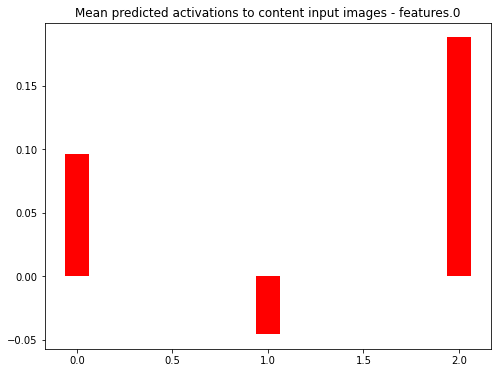

In [87]:
plt.figure(figsize=(8,6))
plt.title("Mean predicted activations to content input images - " + "".join(layers))
X = np.array([0, 1, 2])
plt.bar(X + 0.00,
        [cond_predicted['FFA']['face'].mean(axis=1).mean(),
         cond_predicted['PPA']['face'].mean(axis=1).mean(),
         cond_predicted['LOC']['face'].mean(axis=1).mean()],
       color='r',
       width=0.125,
       label='face')

plt.bar(X + 0.125,
        [cond_predicted['FFA']['place'].mean(axis=1).mean(),
         cond_predicted['PPA']['place'].mean(axis=1).mean(),
         cond_predicted['LOC']['place'].mean(axis=1).mean()],
       color='b',
       width=0.125,
       label='place')

plt.bar(X + 0.25,
        [cond_predicted['FFA']['object'].mean(axis=1).mean(),
         cond_predicted['PPA']['object'].mean(axis=1).mean(),
         cond_predicted['LOC']['object'].mean(axis=1).mean()],
       color='g',
       width=0.125,
       label='object')

plt.xticks(X+0.125, ['FFA', 'PPA', 'LOC'])
_ = plt.legend()


/home/chan21/.conda/envs/bonner-lab-kelsey/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/chan21/.conda/envs/bonner-lab-kelsey/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/chan21/.conda/envs/bonner-lab-kelsey/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code

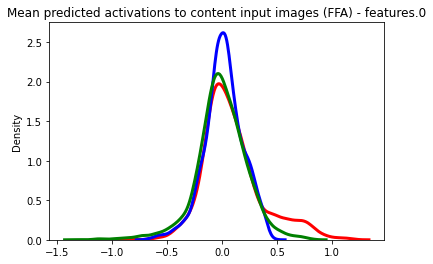

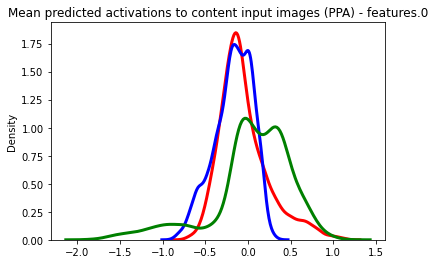

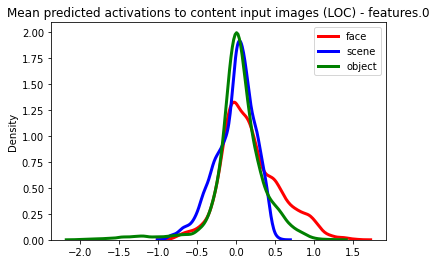

In [86]:
import seaborn as sns

plt.figure()
plt.title("Mean predicted activations to content input images (FFA) - " + "".join(layers))
sns.displot(cond_predicted['FFA']['face'], hist=False, kde=True, 
             color = 'r',
             kde_kws = {'linewidth': 3},
            label = "face")
sns.displot(cond_predicted['FFA']['place'], hist=False, kde=True, 
             color = 'b',
             kde_kws = {'linewidth': 3},
            label = "scene")
sns.displot(cond_predicted['FFA']['object'], hist=False, kde=True, 
             color = 'g',
             kde_kws = {'linewidth': 3},
            label = "object")

plt.figure()
plt.title("Mean predicted activations to content input images (PPA) - " + "".join(layers))
sns.displot(cond_predicted['PPA']['face'], hist=False, kde=True, 
             color = 'r',
             kde_kws = {'linewidth': 3},
            label = "face")
sns.displot(cond_predicted['PPA']['place'], hist=False, kde=True, 
             color = 'b',
             kde_kws = {'linewidth': 3},
            label = "scene")
sns.displot(cond_predicted['PPA']['object'], hist=False, kde=True, 
             color = 'g',
             kde_kws = {'linewidth': 3},
            label = "object")


plt.figure()
plt.title("Mean predicted activations to content input images (LOC) - " + "".join(layers))
sns.displot(cond_predicted['LOC']['face'], hist=False, kde=True, 
             color = 'r',
             kde_kws = {'linewidth': 3},
            label = "face")
sns.displot(cond_predicted['LOC']['place'], hist=False, kde=True, 
             color = 'b',
             kde_kws = {'linewidth': 3},
            label = "scene")
sns.displot(cond_predicted['LOC']['object'], hist=False, kde=True, 
             color = 'g',
             kde_kws = {'linewidth': 3},
            label = "object")

# plt.hist(cond_predicted['FFA']['face'].mean(axis=1), alpha=0.5, color='r', label="face")
# plt.hist(cond_predicted['FFA']['scene'].mean(axis=1), alpha=0.5, color='b', label="place")
# plt.hist(cond_predicted['FFA']['object'].mean(axis=1), alpha=0.5, color='g', label="object")
_ = plt.legend()